Transformer with PyTorch 

In [1]:
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import numpy as np
import torch
import torch.nn as nn
from torchinfo import summary
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, auc


## Step 1: Data Exploration and Preprocessing

In [3]:
trainingFile = 'train.csv'
testingFile = 'test.csv'
columns = ['class', 'title', 'description']
trainingDf = pandas.read_csv(trainingFile, header=None, names=columns)
testingDF = pandas.read_csv(testingFile, header=None, names=columns)


In [4]:
print("Information about training dataframe:")
print(trainingDf.info())
print("Information about testing dataframe:")
print(testingDF.info())
print("First few rows of the Training Data:")
print(trainingDf.head())
print("Basic Statistics for Training Data:")
print(trainingDf.describe())
print("Class distribution:")
print(trainingDf['class'].value_counts())

print("Average word count for title and description columns:")
print(f"Average title word count is {trainingDf['title'].apply(lambda x: len(str(x).split()))}")
print(f"Average description word count is {trainingDf['description'].apply(lambda x: len(str(x).split()))}")



Information about training dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   class        120000 non-null  int64 
 1   title        120000 non-null  object
 2   description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB
None
Information about testing dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7600 entries, 0 to 7599
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class        7600 non-null   int64 
 1   title        7600 non-null   object
 2   description  7600 non-null   object
dtypes: int64(1), object(2)
memory usage: 178.2+ KB
None
First few rows of the Training Data:
   class                                              title  \
0      3  Wall St. Bears Claw Back Into the Black (Reuters)   
1      3  Carlyle L

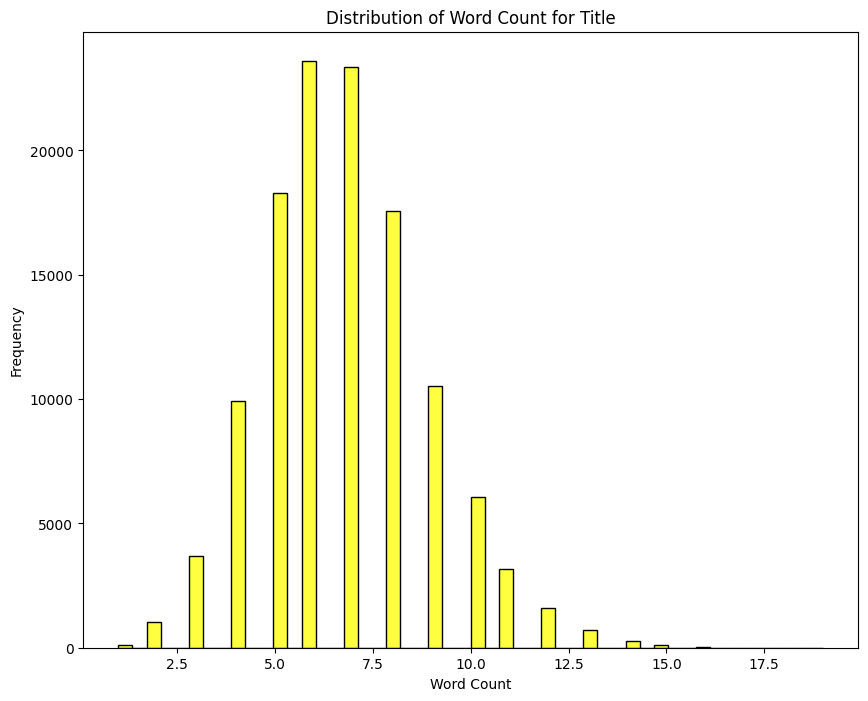

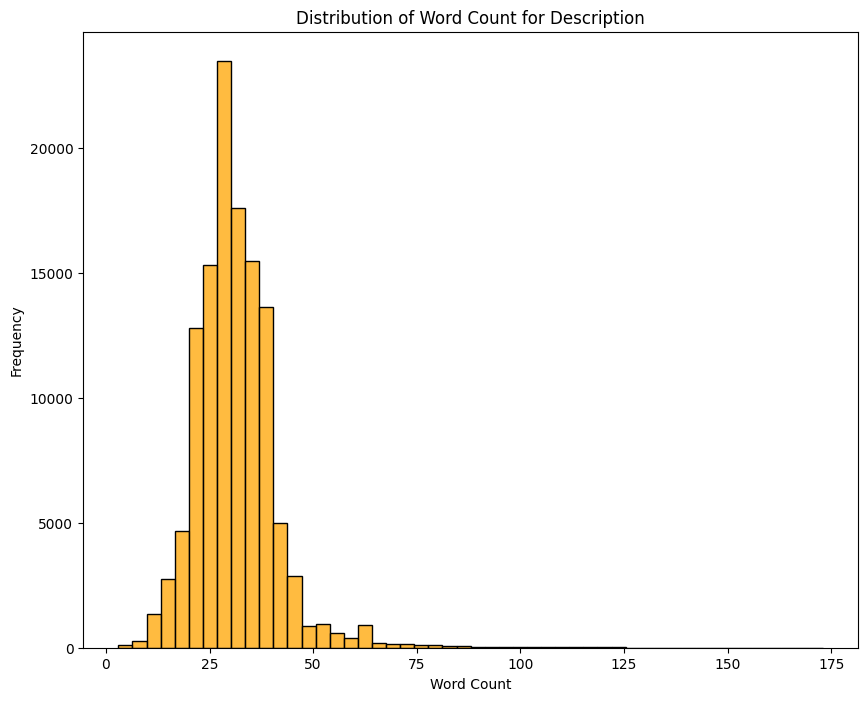

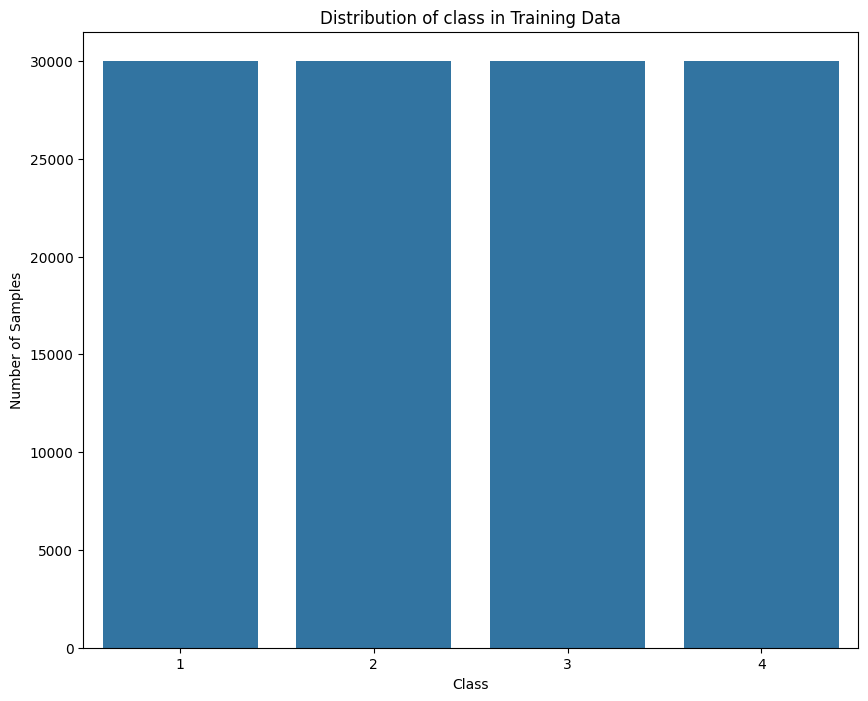

In [5]:

plt.figure(figsize=(10, 8))
sns.histplot(trainingDf['title'].apply(lambda x: len(str(x).split())), bins=50, kde=False, color='yellow')
plt.title('Distribution of Word Count for Title')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 8))
sns.histplot(trainingDf['description'].apply(lambda x: len(str(x).split())), bins=50, kde=False, color='orange')
plt.title('Distribution of Word Count for Description')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 8))
sns.countplot(x='class', data=trainingDf)
plt.title('Distribution of class in Training Data')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()


3. Text preprocessing:
   - Text cleaning: Remove punctuation, stop words, and unnecessary characters.
   - Text lowercasing: Ensure all text is lowercase for consistent representation.
   - Tokenization: Break down the text into individual words (or tokens). Explore libraries like nltk or spaCy for tokenization functionalities. You can also use keras tokenizer or Pytorch tokenizer.
   - Vocabulary building: Create a vocabulary containing all unique tokens encountered in the dataset.
   - Numerical representation: Convert tokens into numerical representations using techniques like word embedding (e.g., Word2Vec, GloVe).

In [7]:
nltk.download('punkt')
nltk.download('stopwords')

def preProcessingText(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in set(stopwords.words('english'))]
    return tokens

def loadGlove(filePath):
    embeddings = {}
    with open(filePath, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

def tokenToGloveEmbeddings(tokens, wordToIndex, embeddingMatrix):
    embeddings = np.zeros((len(tokens), embeddingDimensions))
    for i, token in enumerate(tokens):
        index = wordToIndex.get(token, -1)
        if index != -1:
            embeddings[i] = embeddingMatrix[index]
    return embeddings


trainingDf['titleTokens'] = trainingDf['title'].apply(preProcessingText)
trainingDf['descriptionTokens'] = trainingDf['description'].apply(preProcessingText)
trainingDf['textTokens'] = trainingDf['titleTokens'] + trainingDf['descriptionTokens']
allTheTokens = [token for tokens in trainingDf['textTokens'] for token in tokens]
vocabulary = set(allTheTokens)

print(f"Vocabulary size is {len(vocabulary)}")

gloveEmbeddings = loadGlove('glove.6B.100d.txt')
wordToIndex = {word: idx for idx, word in enumerate(vocabulary)}
embeddingDimensions = 100
embeddingMatrix = np.zeros((len(vocabulary), embeddingDimensions))
for word, idx in wordToIndex.items():
    embeddingVectors = gloveEmbeddings.get(word)
    if embeddingVectors is not None:
        embeddingMatrix[idx] = embeddingVectors

trainingDf['titleEmbeddings'] = trainingDf['titleTokens'].apply(lambda x: tokenToGloveEmbeddings(x, wordToIndex, embeddingMatrix))
trainingDf['descriptionEmbeddings'] = trainingDf['descriptionTokens'].apply(lambda x: tokenToGloveEmbeddings(x, wordToIndex, embeddingMatrix))


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/devanshiverma/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/devanshiverma/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Vocabulary size is 102016


## Step 2: Model Construction

In [9]:

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=50000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class GloVeEmbeddingLayer(nn.Module):
    def __init__(self, vocab_size, embeddingDimensions, embeddingMatrix):
        super(GloVeEmbeddingLayer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embeddingDimensions)
        self.embedding.weight.data.copy_(torch.from_numpy(embeddingMatrix))
        self.embedding.weight.requires_grad = False

    def forward(self, x):
        return self.embedding(x)
    

In [11]:
class TransformerModelForClassification(nn.Module):
    def __init__(self, vocab_size, embeddingDimensions, embeddingMatrix, num_classes, num_heads, num_layers=4, dropout=0.0):
        super(TransformerModelForClassification, self).__init__()
        self.embedding_layer = GloVeEmbeddingLayer(vocab_size, embeddingDimensions, embeddingMatrix)
        self.positional_encoding = PositionalEncoding(embeddingDimensions)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embeddingDimensions,
            nhead=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embeddingDimensions, num_classes)

    def forward(self, x):
        x = self.embedding_layer(x)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        out = self.fc(x)
        return out


In [14]:
embeddingDimensions = 100
num_heads = 10

baseModel = TransformerModelForClassification(
    vocab_size=len(wordToIndex),
    embeddingDimensions=embeddingDimensions,
    embeddingMatrix=embeddingMatrix,
    num_classes=len(trainingDf['class'].unique()),
    num_heads=num_heads
)

summary(baseModel, input_data=torch.randint(low=0, high=len(wordToIndex), size=(32, 100)))

Layer (type:depth-idx)                        Output Shape              Param #
TransformerModelForClassification             [32, 4]                   --
├─GloVeEmbeddingLayer: 1-1                    [32, 100, 100]            --
│    └─Embedding: 2-1                         [32, 100, 100]            (10,201,600)
├─PositionalEncoding: 1-2                     [32, 100, 100]            --
├─TransformerEncoder: 1-3                     [32, 100, 100]            --
│    └─ModuleList: 2-2                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [32, 100, 100]            452,548
│    │    └─TransformerEncoderLayer: 3-2      [32, 100, 100]            452,548
│    │    └─TransformerEncoderLayer: 3-3      [32, 100, 100]            452,548
│    │    └─TransformerEncoderLayer: 3-4      [32, 100, 100]            452,548
├─Linear: 1-4                                 [32, 4]                   404
Total params: 12,012,196
Trainable params: 1,810,596
Non-trainab

## Step 3: Training the Transformer

In [16]:

labelEncoder = LabelEncoder()
trainingDf['class_encoded'] = labelEncoder.fit_transform(trainingDf['class'])

def tokensToIndices(tokens, wordToIndex):
    return [wordToIndex.get(token, 0) for token in tokens]

X = trainingDf['textTokens'] 
y = trainingDf['class_encoded']
XIndices = [tokensToIndices(tokens, wordToIndex) for tokens in X]
max_len = max([len(seq) for seq in XIndices])
XIndicesPadded = [seq[:max_len] + [0] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len] for seq in XIndices]

XTrainIndices, XValIndices, yTrain, yVal = train_test_split(XIndicesPadded, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(XTrainIndices)
X_val_tensor = torch.tensor(XValIndices)
yTrain_tensor = torch.tensor(yTrain.values)
yVal_tensor = torch.tensor(yVal.values)

trainDataset = TensorDataset(X_train_tensor, yTrain_tensor)
valDataset = TensorDataset(X_val_tensor, yVal_tensor)

trainLoader = DataLoader(trainDataset, batch_size=32, shuffle=True)
valLoader = DataLoader(valDataset, batch_size=32, shuffle=False)


In [18]:


# Define the training function with accuracy tracking
def trainModel(model, trainLoader, valLoader, num_epochs=10, learning_rate=1e-4):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    trainAccuracies = []
    val_accuracies = []
    trainLosses = []
    valLosses = []    

    for epoch in range(num_epochs):

        model.train()
        runningTrainLoss = 0.0
        correctTrain = 0
        totalTrain = 0

        for inputs, labels in trainLoader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            runningTrainLoss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            totalTrain += labels.size(0)
            correctTrain += (predicted == labels).sum().item()

        train_loss = runningTrainLoss / totalTrain
        train_accuracy = 100 * correctTrain / totalTrain
        trainLosses.append(train_loss)
        trainAccuracies.append(train_accuracy)

        model.eval()
        runningValLoss = 0.0
        correctVal = 0
        totalVal = 0

        with torch.no_grad():
            for inputs, labels in valLoader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                runningValLoss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                totalVal += labels.size(0)
                correctVal += (predicted == labels).sum().item()

        val_loss = runningValLoss / totalVal
        val_accuracy = 100 * correctVal / totalVal
        valLosses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch is {epoch+1}, "
              f"Training Loss is {train_loss:.4f}, Training Accuracy is {train_accuracy:.2f}%, "
              f"Validation Loss is {val_loss:.4f}, Validation Accuracy is {val_accuracy:.2f}%")

    return trainLosses, valLosses, trainAccuracies, val_accuracies


In [19]:

trainLosses, valLosses, trainAccuracies, val_accuracies = trainModel(
    baseModel,
    trainLoader,
    valLoader,
    num_epochs=5,
    learning_rate=0.01
)


Epoch is 1, Training Loss is 1.3907, Training Accuracy is 25.16%, Validation Loss is 1.3863, Validation Accuracy is 25.31%
Epoch is 2, Training Loss is 1.3884, Training Accuracy is 25.36%, Validation Loss is 1.3866, Validation Accuracy is 25.31%
Epoch is 3, Training Loss is 1.3886, Training Accuracy is 25.06%, Validation Loss is 1.3948, Validation Accuracy is 25.24%
Epoch is 4, Training Loss is 1.3885, Training Accuracy is 25.11%, Validation Loss is 1.3876, Validation Accuracy is 24.82%
Epoch is 5, Training Loss is 1.3885, Training Accuracy is 24.88%, Validation Loss is 1.3875, Validation Accuracy is 24.63%


## Step 4: Evaluation and Optimization

In [21]:

testingDF['titleTokens'] = testingDF['title'].apply(preProcessingText)
testingDF['descriptionTokens'] = testingDF['description'].apply(preProcessingText)
testingDF['textTokens'] = testingDF['titleTokens'] + testingDF['descriptionTokens']

testingDF['titleEmbeddings'] = testingDF['titleTokens'].apply(lambda x: tokenToGloveEmbeddings(x, wordToIndex, embeddingMatrix))
testingDF['descriptionEmbeddings'] = testingDF['descriptionTokens'].apply(lambda x: tokenToGloveEmbeddings(x, wordToIndex, embeddingMatrix))

labelEncodertestData = LabelEncoder()
labelEncodertestData.fit(trainingDf['class'])
testingDF['class_encoded'] = labelEncodertestData.transform(testingDF['class'])

testTextsIndices = [tokensToIndices(tokens, wordToIndex) for tokens in testingDF['textTokens']]
max_len_T = max([len(seq) for seq in testTextsIndices])
testTextsIndicesPadded = [seq[:max_len_T] + [0] * (max_len_T - len(seq)) if len(seq) < max_len_T else seq[:max_len_T] for seq in testTextsIndices]

testTextsTensor = torch.tensor(testTextsIndicesPadded)
testLabelsTensor = torch.tensor(testingDF['class_encoded'].values)

testDataset = TensorDataset(testTextsTensor, testLabelsTensor)
testLoader = DataLoader(testDataset, batch_size=32, shuffle=False)


In [22]:

def evaluateModel(model, testLoader, device):
    model.eval()
    allLabels = []
    allPreds = []
    runningLoss = 0.0
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for batch in testLoader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, dim=1)
            loss = criterion(outputs, labels)
            runningLoss += loss.item()
            allPreds.extend(preds.cpu().numpy())
            allLabels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(allLabels, allPreds)

    precision, recall, f1, _ = precision_recall_fscore_support(allLabels, allPreds, average='weighted')
    fpr, tpr, thresholds = roc_curve(allLabels, allPreds, pos_label=1)
    roc_auc = auc(fpr, tpr)

    avgLoss = runningLoss / len(testLoader)

    return avgLoss, accuracy, precision, recall, f1, fpr, tpr, roc_auc


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
testLossBase, testAccBase, testPrecisionBase, testRecallBase, testF1Base, testfprBase, testtprBase, testRocaucBase = evaluateModel(baseModel, testLoader, device)
print(f"Test Accuracy for base: {testAccBase}")
print(f"Test Precision for base: {testPrecisionBase}")
print(f"Test Recall for base: {testRecallBase}")
print(f"Test F1 Score for base: {testF1Base}")

Test Accuracy for base: 0.25
Test Precision for base: 0.0625
Test Recall for base: 0.25
Test F1 Score for base: 0.1


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [24]:
class TransformerModelForOptimization(nn.Module):
    def __init__(self, vocab_size, embeddingDimensions, embeddingMatrix, num_classes, num_heads, num_layers=4, dropout=0.0, weight_decay=0.0):
        super(TransformerModelForOptimization, self).__init__()
        self.embedding_layer = GloVeEmbeddingLayer(vocab_size, embeddingDimensions, embeddingMatrix)
        self.positional_encoding = PositionalEncoding(embeddingDimensions)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embeddingDimensions,
            nhead=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embeddingDimensions, num_classes)
        self.dropout = dropout
        self.weight_decay = weight_decay

    def forward(self, x):
        x = self.embedding_layer(x)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        out = self.fc(x)
        return out


In [27]:
def trainWithOptimizations(trainLoader, valLoader, device, vocab_size, embeddingDimensions, embeddingMatrix, num_classes, max_epochs=10, patience=3):
    bestModel, bestModelMetrics, bestModelValAcc = None, None, 0
    bestDropout, bestWeightDecay = None, None
    bestHistory = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    dropout_values = [0.3]
    weight_decayValues = [0.1]
    early_stopping_triggered = False

    for dropout, weight_decay in zip(dropout_values, weight_decayValues):
        print(f"Training model with dropout value of {dropout} and weight_decay value of {weight_decay}")

        model = TransformerModelForOptimization(
            vocab_size=vocab_size,
            embeddingDimensions=embeddingDimensions,
            embeddingMatrix=embeddingMatrix,
            num_classes=num_classes,
            num_heads=10,
            dropout=dropout,
            weight_decay=weight_decay
        ).to(device)
        
        optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=weight_decay)
        criterion = nn.CrossEntropyLoss()

        history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

        epochsNoImprovement = 0
        early_stopping_triggered = False

        for epoch in range(max_epochs):
            model.train()
            runningLoss = 0.0
            correctPreds = 0
            totalSamples = 0
            allTrainPreds = []
            allTrainLabels = []

            for batch in trainLoader:
                inputs, labels = batch
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                runningLoss += loss.item()
                _, preds = torch.max(outputs, dim=1)
                correctPreds += torch.sum(preds == labels)
                totalSamples += labels.size(0)
                allTrainPreds.extend(preds.cpu().numpy())
                allTrainLabels.extend(labels.cpu().numpy())

            train_acc = correctPreds / totalSamples
            train_loss = runningLoss / len(trainLoader)

            val_loss, val_acc, val_precision, val_recall, val_f1, fpr, tpr, roc_auc = evaluateModel(model, valLoader, device)
            
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)

            print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f} | "
                  f"Validation Accuracy: {val_acc:.4f} | Validation F1: {val_f1:.4f}")

            if val_acc > bestModelValAcc:
                bestModelValAcc = val_acc
                bestModel = model
                bestModelMetrics = {
                    "train_loss": train_loss, "val_loss": val_loss, "train_acc": train_acc, "val_acc": val_acc,
                    "val_precision": val_precision, "val_recall": val_recall, "val_f1": val_f1, "roc_auc": roc_auc
                }
                bestDropout = dropout
                bestWeightDecay = weight_decay
                bestHistory = history
                epochsNoImprovement = 0
            else:
                epochsNoImprovement += 1
                if epochsNoImprovement >= patience:
                    print(f"Early stopping triggered at epoch {epoch+1} for dropout={dropout}, weight_decay={weight_decay}.")
                    early_stopping_triggered = True
                    break

        if early_stopping_triggered:
            continue

    return bestModel, bestModelMetrics, bestHistory, bestDropout, bestWeightDecay


In [28]:
bestModel, bestModelMetrics, bestHistory, bestDropout, bestWeightDecay = trainWithOptimizations(
    trainLoader=trainLoader,
    valLoader=valLoader,
    device=device,
    vocab_size=len(vocabulary),
    embeddingDimensions=embeddingDimensions,
    embeddingMatrix=embeddingMatrix,
    num_classes=4,
    max_epochs=5,
    patience=3
)

print("Best Model Metrics:")
print(bestModelMetrics)

print("Best Model Dropout:")
print(bestDropout)

print("Best Model Weight Decay:")
print(bestWeightDecay)

testLossBest, testAccBest, testPrecisionBest, testRecallBest, testF1Best, testfprBest, testtprBest, testRocaucBest = evaluateModel(bestModel, testLoader, device)


Training model with dropout value of 0.3 and weight_decay value of 0.1


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1 | Train Loss: 1.3881 | Train Accuracy: 0.2496 | Validation Accuracy: 0.2524 | Validation F1: 0.1017


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2 | Train Loss: 1.3869 | Train Accuracy: 0.2477 | Validation Accuracy: 0.2482 | Validation F1: 0.0987


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3 | Train Loss: 1.3873 | Train Accuracy: 0.2503 | Validation Accuracy: 0.2524 | Validation F1: 0.1017


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4 | Train Loss: 1.3873 | Train Accuracy: 0.2479 | Validation Accuracy: 0.2463 | Validation F1: 0.0973
Early stopping triggered at epoch 4 for dropout=0.3, weight_decay=0.1.
Best Model Metrics:
{'train_loss': 1.38806796058019, 'val_loss': 1.3867724204063416, 'train_acc': tensor(0.2496), 'val_acc': 0.2524166666666667, 'val_precision': 0.06371417361111112, 'val_recall': 0.2524166666666667, 'val_f1': 0.10174596890456229, 'roc_auc': 0.5}
Best Model Dropout:
0.3
Best Model Weight Decay:
0.1


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [30]:
print(f"Test Accuracy for best Model: {testAccBest}")
print(f"Training Accuracy for best Model: {bestHistory['train_acc']}")
print(f"Training Loss for best Model: {bestHistory['train_loss']}")
print(f"Validation Accuracy for best Model: {bestHistory['val_acc']}")
print(f"Validation Loss for best Model: {bestHistory['val_loss']}")


Test Accuracy for best Model: 0.25
Training Accuracy for best Model: [tensor(0.2496), tensor(0.2477), tensor(0.2503), tensor(0.2479)]
Training Loss for best Model: [1.38806796058019, 1.3868629651467006, 1.387273386279742, 1.38733300614357]
Validation Accuracy for best Model: [0.2524166666666667, 0.24816666666666667, 0.2524166666666667, 0.24629166666666666]
Validation Loss for best Model: [1.3867724204063416, 1.3873919820785523, 1.386344125588735, 1.3865585691134135]


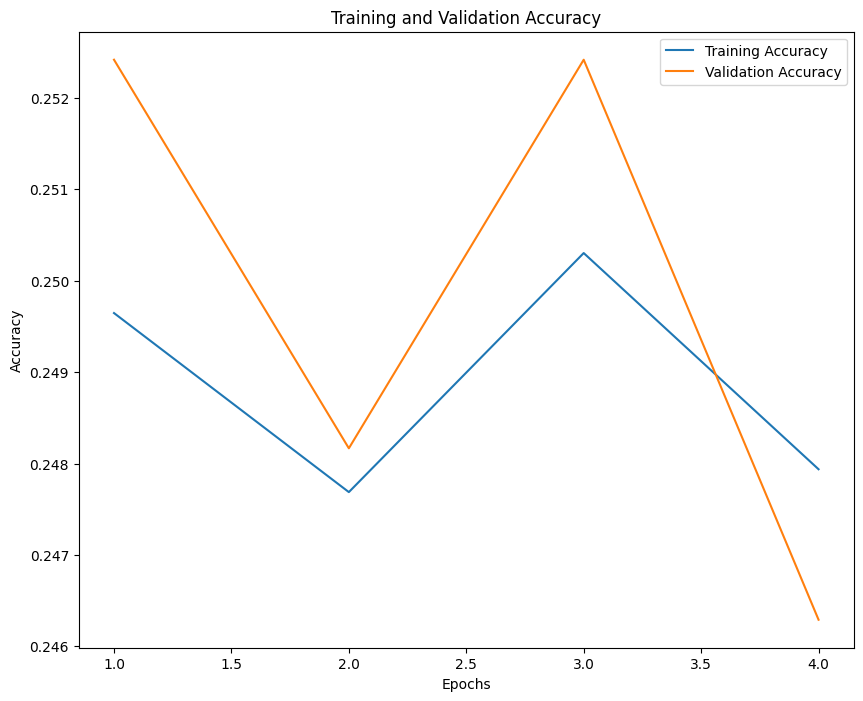

In [ ]:
epochs = range(1, len(bestHistory['train_loss']) + 1)

plt.figure(figsize=(10, 8))
plt.plot(epochs, bestHistory['train_acc'], label='Training Accuracy')
plt.plot(epochs, bestHistory['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

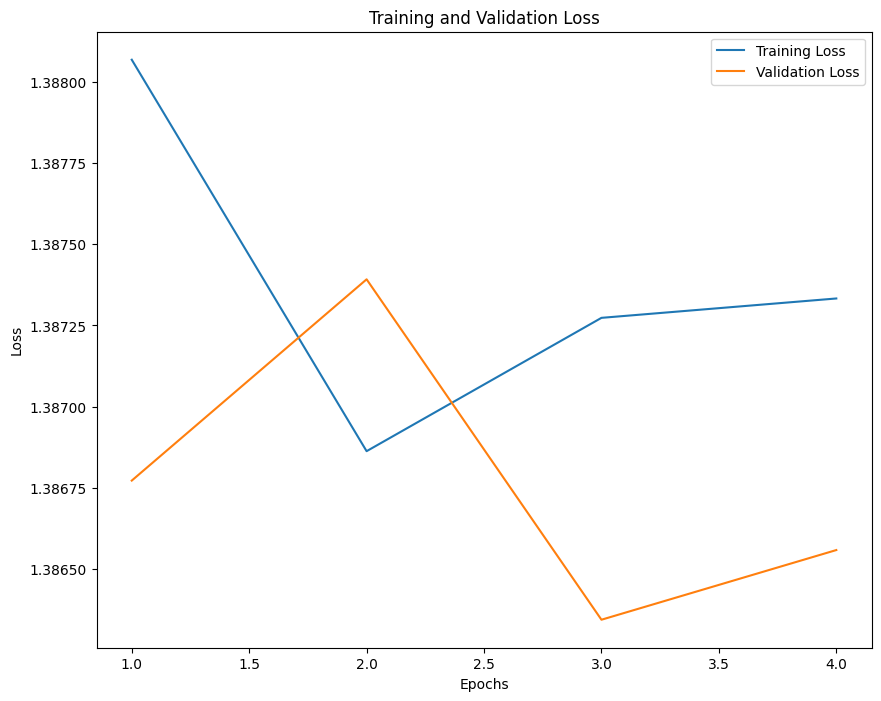

In [32]:
plt.figure(figsize=(10, 8))
plt.plot(epochs, bestHistory['train_loss'], label='Training Loss')
plt.plot(epochs, bestHistory['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [33]:
print(f"Test Precision for best Model: {testPrecisionBest}")
print(f"Test Recall for best Model: {testRecallBest}")
print(f"Test F1 Score for best Model: {testF1Best}")

Test Precision for best Model: 0.0625
Test Recall for best Model: 0.25
Test F1 Score for best Model: 0.1


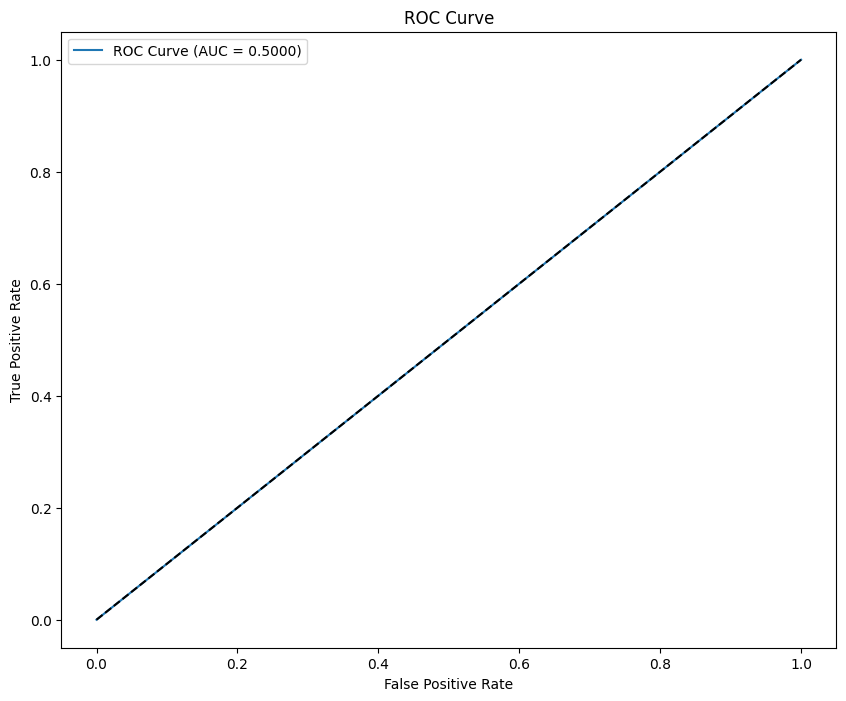

In [34]:
plt.figure(figsize=(10, 8))
plt.plot(testfprBest, testtprBest, label=f'ROC Curve (AUC = {testRocaucBest:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='upper left')
plt.show()